In [1]:
from django.conf import settings
settings.configure(BASE_DIR='/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska/djangoapp',)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append('/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska') 

In [2]:
from djangoapp.news.scripts.llm import *
from djangoapp.news.scripts.model_loader2 import *
from djangoapp.news.scripts.nlp import *

In [3]:
import pandas as pd
import pickle  
from tqdm.notebook import tqdm 

df = pd.read_csv('../all_datasets/data/merged_titles_labels.csv')

In [4]:
df_test = df[df['sample'] == 'test'].reset_index(drop=True)
df_test

df_test_text = df_test[df_test['text'].notnull()].reset_index(drop=True)
df_test_no_text = df_test[df_test['text'].isnull()].reset_index(drop=True)

In [5]:
model_loader = ModelLoader()
llm = model_loader.llm 
vertex = model_loader.vertex
summarizer = model_loader.summarizer

## Testing VertexAI LLM

In [6]:
# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df_test.iloc[[313, 1418, 1863, 2039, 2315]].reset_index(drop=True)

In [8]:
import copy as cp
datasets_vertex = {
    # 'df_test': df_test,
    # 'df_test_text': df_test_text,
    # 'df_test_no_text': df_test_no_text,
    # 'df_problem': df_problem,
}


for dataset_name in datasets_vertex.keys():
    if os.path.isfile('vertex_results.csv'):
        dataset = pd.read_csv('vertex_results.csv')
        continue

    dataset = cp.deepcopy(datasets_vertex[dataset_name])
    print(f'Predicting {dataset_name}...')
    dataset['with_summary_error'] = [False] * dataset.shape[0]
    dataset['without_summary_error'] = [False] * dataset.shape[0]

    for i, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        title = row['title']
        if pd.notnull(row['text']):
            text = row['text']
            summary = model_loader.summarizer(
                text, max_length=200, min_length=40, do_sample=False
            )
            try:
                dataset.loc[i, 'vertex_prediction_with_summary'] = vertex.run(title, summary)
            except:
                print(f'Error in {i} row')
                dataset.loc[i, 'vertex_prediction_with_summary'] = None
                dataset.loc[i, 'with_summary_error'] = True
        else:
            dataset.loc[i, 'vertex_prediction_with_summary'] = None
        
        try:
            dataset.loc[i, 'vertex_prediction_without_summary'] = vertex.run(title)
        except:
            print(f'Error in {i} row')
            dataset.loc[i, 'vertex_prediction_without_summary'] = None
            dataset.loc[i, 'without_summary_error'] = True

In [9]:
# datasets_vertex['df_test'] = dataset
# df_test = datasets_vertex['df_test']

In [10]:
# save df
# df_test.to_csv('vertex_results.csv', index=False)

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_test = pd.read_csv('vertex_results copy.csv')
df_test

## Dane `title` (2585)

In [15]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_without_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_without_summary'].values    

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')



F1:          0.7477
Recall:      0.9558
Precision:   0.6140
Accuracy:    0.6837


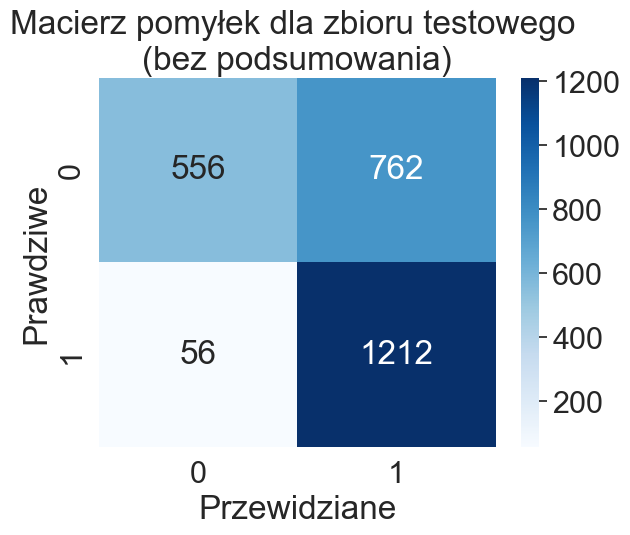

In [18]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.set(font_scale=2)
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek dla zbioru testowego \n(bez podsumowania)')
plt.show()

## Dane `title + text` artykułów (992)

### Predykcja z podsumowaniem

In [19]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_with_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_with_summary'].values

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')

F1:          0.7228
Recall:      0.7801
Precision:   0.6734
Accuracy:    0.7147


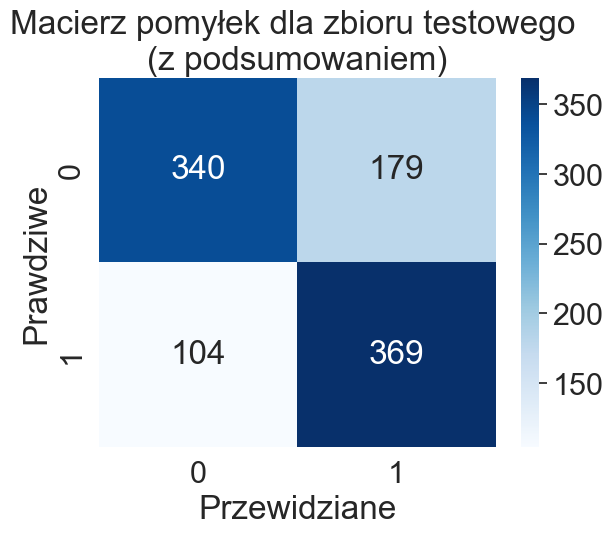

In [20]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek dla zbioru testowego \n(z podsumowaniem)')
plt.show()

### Predykcja bez podsumowania

In [28]:
df_test_no_text_no_nan = df_test[df_test['vertex_prediction_with_summary'].notnull()].reset_index(drop=True)
y_true = df_test_no_text_no_nan['is_clickbait'].values
y_pred = df_test_no_text_no_nan['vertex_prediction_without_summary'].values

y_pred = y_pred.astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')

F1:          0.7252
Recall:      0.9260
Precision:   0.5959
Accuracy:    0.6653


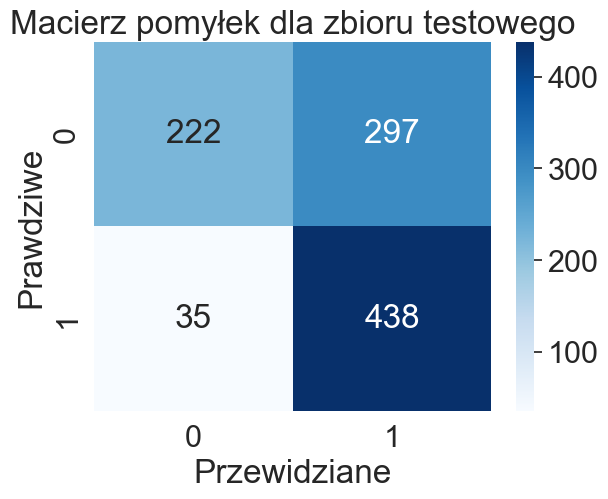

In [29]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek dla zbioru testowego')
plt.show()

## Tabelka

In [74]:
import copy as cp
df = cp.deepcopy(df_test)
df_all_datasets = cp.deepcopy(df)
df_clickbait_dataset = df[df['dataset']=='clickbait-dataset'].reset_index(drop=True)
df_fake_news = df[df['dataset']=='fake-news'].reset_index(drop=True)

df_all_datasets.shape, df_clickbait_dataset.shape, df_fake_news.shape

((2590, 9), (1595, 9), (995, 9))

In [63]:
dataset_combinations = ['data_all_datasets', 'data_fake-news', 'data_clickbait-dataset']
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
summary_combinations = ['with_summary', 'without_summary']


In [ ]:
results = dict()


for dataset in dataset_combinations:
    results[dataset] = dict()
    for summary in summary_combinations:
        results[dataset][summary] = dict()
        for metric in metrics:
            results[dataset][summary][metric] = None
    
results['data_all_datasets']['with_summary']['accuracy'] = 0.0
results



In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


for dataset in tqdm(dataset_combinations, desc='datasets'):
    if dataset == 'data_all_datasets':
        df_temp = cp.deepcopy(df_all_datasets)
        dataset_name = 'all_datasets'
    elif dataset == 'data_fake-news':
        df_temp = cp.deepcopy(df_fake_news)
        dataset_name = 'fake-news'
    elif dataset == 'data_clickbait-dataset':
        df_temp = cp.deepcopy(df_clickbait_dataset)
        dataset_name = 'clickbait-dataset'

    for summary in tqdm(summary_combinations, desc='summary'):
        if summary == 'with_summary':
            df_tempp = df_temp[df_temp['vertex_prediction_with_summary'].notnull()].reset_index(drop=True)
        elif summary == 'without_summary':
            df_tempp = df_temp[df_temp['vertex_prediction_without_summary'].notnull()].reset_index(drop=True)
        
        
        print(dataset, df_temp.shape)
        y_true = df_tempp['is_clickbait'].values

        prediction_name = f'vertex_prediction_{summary}'

        y_pred = df_tempp[prediction_name].values
        
        y_pred = y_pred.astype(int)


        results[dataset][summary]['accuracy'] = accuracy_score(y_true, y_pred)
        results[dataset][summary]['precision'] = precision_score(y_true, y_pred)
        results[dataset][summary]['recall'] = recall_score(y_true, y_pred)
        results[dataset][summary]['f1-score'] = f1_score(y_true, y_pred)




In [ ]:
# unpack the results to a dataframe
results_list = []
results_df = pd.DataFrame()

for dataset in dataset_combinations:
    for summary in summary_combinations:
        for metric in metrics:
            results_list.append([ dataset, summary, metric, results[dataset][summary][metric]])

results_df = pd.DataFrame(results_list, columns=[ 'dataset', 'summary', 'metric', 'value'])
results_df

In [77]:
res = results_df

In [78]:
res_pivot = res.pivot_table(index=['dataset'], columns=['summary', 'metric'], values='value', aggfunc='mean').reset_index()
res_pivot = res_pivot.transpose()

res_pivot


0                       1  \
summary         metric                                                 
dataset                    data_all_datasets  data_clickbait-dataset   
with_summary    accuracy            0.714718                     NaN   
                f1-score            0.722821                     0.0   
                precision           0.673358                     0.0   
                recall              0.780127                     0.0   
without_summary accuracy            0.683681                0.695352   
                f1-score            0.747687                0.761201   
                precision           0.613982                0.624899   
                recall              0.955836                0.973552   

                                        2  
summary         metric                     
dataset                    data_fake-news  
with_summary    accuracy         0.714718  
                f1-score         0.722821  
                precision        0.673358  
                recall           0.780127  
without_summary accuracy          0.66499  
                f1-score         0.725021  
                precision        0.595658  
                recall            0.92616